# SageMaker Pipelines - Invoking a tenant specific endpoint (SaaS)

This notebook demonstrates invoking a tenant's model hosted on a SageMaker single model endpoint.

This notebook has been tested on SageMaker Studio using the `Data Science` kernel on an `ml.t3.medium`. 


Please make sure your execution role attached to your Studio user profile has `iam:CreatePolicy, iam:CreateRole, iam:AttachRolePolicy and SageMakerFullAccess` permissions/policy attached.

---

##  Create single model endpoint for a tenant

### Set up

Below we will retrieve the the `image_uri` we will use to host the models with. We will be using the SageMaker Large Model Inference image. We will also set the S3 location where the tenant's model are saved so that the SageMaker endpoint can access it. 

In [57]:
import boto3

region = boto3.Session().region_name
# inference_image_uri = f"{account_id}.dkr.ecr.{region}.amazonaws.com/djl-ds:latest"
inference_image_uri = (
    f"763104351884.dkr.ecr.{region}.amazonaws.com/djl-inference:0.20.0-deepspeed0.7.5-cu116"
)

inference_image_uri

'763104351884.dkr.ecr.us-east-1.amazonaws.com/djl-inference:0.20.0-deepspeed0.7.5-cu116'

### Use tenant1's model

We will deploy tenant1's model to a SageMaker endpoint. 

In [58]:
import sagemaker
sagemaker_session = sagemaker.Session()
default_bucket = sagemaker_session.default_bucket()

tenant_id = "tenant1"
app_id = "app1"
version= 0

model_location = f"s3://{default_bucket}/{tenant_id}/model_artifacts/{tenant_id}-{app_id}.model.{version}.tar.gz"

print(f"Tenant's model located at: {model_location}")

Tenant's model located at: s3://sagemaker-us-east-1-171503325295/tenant1/model_artifacts/tenant1-app1.model.0.tar.gz


### Create SageMaker Model entity

In [59]:
import time
from sagemaker import get_execution_role
sess = boto3.Session()
sm_client = sess.client("sagemaker")
role = get_execution_role()


sm_model_name = f"flan-t5-{tenant_id}-{app_id}" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

create_model_response = sm_client.create_model(
    ModelName=sm_model_name,
    ExecutionRoleArn=role,
    PrimaryContainer={
        "Image": inference_image_uri,
        "ModelDataUrl": model_location
    },
    
)
model_arn = create_model_response["ModelArn"]

print("Model Arn: " + create_model_response["ModelArn"])

Model Arn: arn:aws:sagemaker:us-east-1:171503325295:model/flan-t5-tenant1-app12023-05-15-22-43-29


### Create SageMaker Endpoint Configuration

In [60]:
endpoint_config_name = f"flan-t5-{tenant_id}-{app_id}" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.g5.12xlarge",
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
            "ModelDataDownloadTimeoutInSeconds": 3600, 
            "ContainerStartupHealthCheckTimeoutInSeconds": 3600, 
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

Endpoint Config Arn: arn:aws:sagemaker:us-east-1:171503325295:endpoint-config/flan-t5-tenant1-app12023-05-15-22-43-30


In [61]:
endpoint_name = f"flan-t5-{tenant_id}-{app_id}" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name,  Tags=[{"Key":"TenantID", "Value":f"{tenant_id}"}]
)

print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

Endpoint Arn: arn:aws:sagemaker:us-east-1:171503325295:endpoint/flan-t5-tenant1-app12023-05-15-22-43-31


In [62]:
waiter = sm_client.get_waiter("endpoint_in_service")
print("Waiting for endpoint to create...")
waiter.wait(EndpointName=endpoint_name)
resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
print(f"Endpoint Status: {resp['EndpointStatus']}")

print("Arn: " + resp["EndpointArn"])

Waiting for endpoint to create...
Endpoint Status: InService
Arn: arn:aws:sagemaker:us-east-1:171503325295:endpoint/flan-t5-tenant1-app12023-05-15-22-43-31


### Create ABAC role for invocation (Bridge approach)
In this section we create an IAM role (`DemoTenantPipelineSMEInvokeRole`) and policy which only allows invocation to a tenant specific endpoint.

First we create a policy for the role that restricts access to an endpoint which is taged with the specific tenant (`aws:PrincipalTag/TenantID`). `aws:PrincipalTag/TenantID` will match the principal thats making the API call. I.e. when tenant1 makes InvokeEndpoint `aws:PrincipalTag/TenantID` will be of the value `tenant1` 

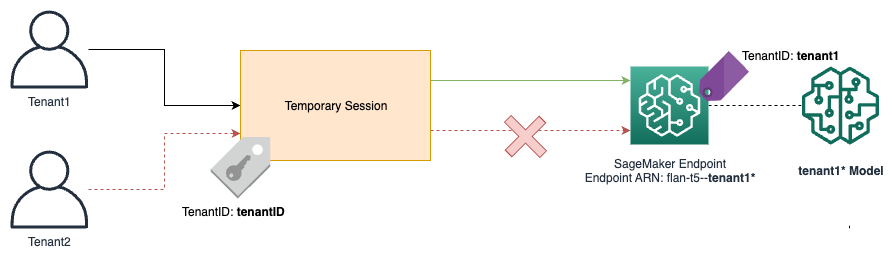

In order to conform with the policy above we will need to assume the `DemoTenantPipelineSMEInvokeRole` and provide the session TenantID tag corresponding to the specific tenant. 

For this example, we are using the SageMaker Studo execution role to Assume the `DemoTenantPipelineSMEInvokeRole`.  

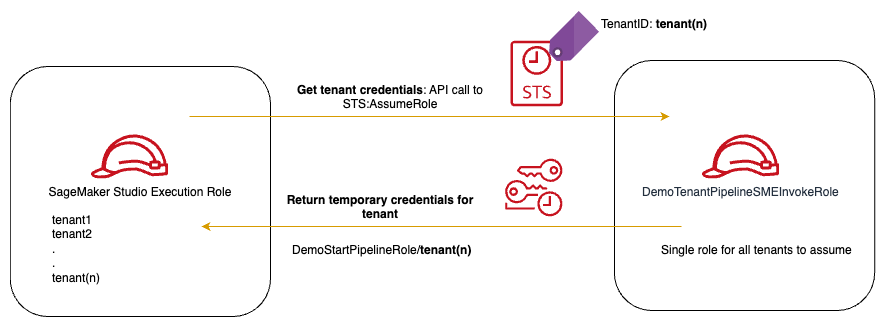

In [70]:
import boto3
import json
import sagemaker.session

sts = boto3.client('sts')
iam = boto3.client('iam')
region = boto3.session.Session().region_name
account_id = sts.get_caller_identity()['Account']

sagemaker_exec_role=sagemaker.session.get_execution_role().split('/')[-1]

invoke_policy_name="DemoTenantPipelineSMEInvokePolicy"

invoke_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": "sagemaker:InvokeEndpoint",
            "Resource": f"arn:aws:sagemaker:{region}:{account_id}:endpoint/flan-t5-${{aws:PrincipalTag/TenantID}}-*",
            "Condition": {
                "StringEquals": {
                    "aws:ResourceTag/TenantID": "${aws:PrincipalTag/TenantID}"
                }
            }
        }
    ]
}

try:
    invoke_policy = iam.create_policy(
        PolicyName=invoke_policy_name,
        PolicyDocument=json.dumps(invoke_policy_document)
    )
    
except iam.exceptions.EntityAlreadyExistsException:
    # If the policy already exists, get its ARN
    policy = iam.get_policy(PolicyArn=f"arn:aws:iam::{account_id}:policy/{invoke_policy_name}")

    # Print the ARN of the existing IAM policy
    print(f"The IAM policy {invoke_policy_name} already exists with ARN {policy['Policy']['Arn']}")


The IAM policy DemoTenantPipelineSMEInvokePolicy already exists with ARN arn:aws:iam::171503325295:policy/DemoTenantPipelineSMEInvokePolicy



Now that the policy is created we need to create the role. In the trust policy we will only allow the SageMaker Studio execution role to assume and make sure tags have to be provided when assuming.


In [71]:
inovke_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": {
                "AWS": f"arn:aws:sts::{account_id}:assumed-role/{sagemaker_exec_role}/SageMaker"
            },
            "Action": ["sts:AssumeRole","sts:TagSession"],
            "Condition": {
                "StringLike": {
                    "aws:RequestTag/TenantID": "tenant*"
                }
            }
        }
    ]
}


try:
    invoke_role_name = "DemoTenantPipelineSMEInvokeRole"
    role=iam.create_role(
        RoleName=invoke_role_name,
        AssumeRolePolicyDocument=json.dumps(inovke_role_policy_document)
    )

    iam.attach_role_policy(
        RoleName=invoke_role_name,
        PolicyArn=f"arn:aws:iam::{account_id}:policy/{invoke_policy_name}"
    )
except iam.exceptions.EntityAlreadyExistsException:
    role = iam.get_role(RoleName=invoke_role_name)

    # Print the ARN of the existing IAM role
    print(f"The IAM role {invoke_role_name} already exists with ARN {role['Role']['Arn']}")

The IAM role DemoTenantPipelineSMEInvokeRole already exists with ARN arn:aws:iam::171503325295:role/DemoTenantPipelineSMEInvokeRole


### Invoke tenant's model
For a given `tenant_id`, if you provide its `TargetModel` name (which will start with tenant id) you will be able to invoke the endpoint  successsfully. But if you provide `TargetModel` name of a different tenant you will get `AccessDeniedException`.

#### Create temp session for tenant1

In [72]:
import time 
wait_time=15
print("Waiting for {} seconds for role creation to propagate ...".format(wait_time))

# Wait for the specified number of seconds
time.sleep(wait_time)

print("Finished waiting!")

Waiting for 15 seconds for role creation to propagate ...
Finished waiting!


In [73]:
from scripts import utils
tenant_id="tenant1"
invoke_temp_session = utils.create_temp_session(role['Role']['Arn'], tenant_id)

Assumed role ARN: arn:aws:sts::171503325295:assumed-role/DemoTenantPipelineSMEInvokeRole/tenant1


#### Invoke tenant1's model

In [74]:
import boto3
import json
import time
from scripts import utils

inputs = "Prompt: Why do gas prices change daily but other goods remain almost constant ? I understand that fruits and similar items can change in price due to the growing seasons , but even then it ’s not that much of a change . Why does gas change every day ? Explain like I'm five."

invoke_sagemaker_client = invoke_temp_session.client('sagemaker-runtime')

prompts = [inputs]
response_model = invoke_sagemaker_client.invoke_endpoint(
            EndpointName=endpoint_name,
            Body=json.dumps(
            {
                "inputs": prompts,
                
                "parameters": {
                    "min_length":25,
                    "max_length":100,
                    "temperature":1.0,
                    'do_sample': True,
                    'no_repeat_ngram_size': 2
                },
            }
            ),
            ContentType="application/json",
        )

output = json.loads(response_model['Body'].read().decode('utf8'))

print(output)

{'outputs': ["Gasoline is a product like fruits. In food, price changes may or may not correlate with crops'growing seasons and may fall based on market conditions - which means that prices may decline with bad news and rise with good news for certain crops and produce... But when talking about gas it ’s something that genuinely changes every day and there s no real rhyme or reason to it beyond what markets deem healthy and what oil companies impose "]}


#### Confirm tenant2 cant invoke tenant1's endpoint 

In [68]:
from scripts import utils
tenant_id="tenant2"
invoke_temp_session2 = utils.create_temp_session(role['Role']['Arn'], tenant_id)

Assumed role ARN: arn:aws:sts::171503325295:assumed-role/DemoTenantPipelineSMEInvokeRole/tenant2


In [69]:
invoke_sagemaker_client2 = invoke_temp_session2.client('sagemaker-runtime')

prompts = [inputs]
response_model = invoke_sagemaker_client2.invoke_endpoint(
            EndpointName=endpoint_name,
            Body=json.dumps(
            {
                "inputs": prompts,
                
                "parameters": {
                    "min_length":25,
                    "max_length":100,
                    "temperature":1.0,
                    'do_sample': True,
                    'no_repeat_ngram_size': 2
                },
            }
            ),
            ContentType="application/json",
        )

output = json.loads(response_model['Body'].read().decode('utf8'))

print(output)

ClientError: An error occurred (AccessDeniedException) when calling the InvokeEndpoint operation: User: arn:aws:sts::171503325295:assumed-role/DemoTenantPipelineSMEInvokeRole/tenant2 is not authorized to perform: sagemaker:InvokeEndpoint on resource: arn:aws:sagemaker:us-east-1:171503325295:endpoint/flan-t5-tenant1-app12023-05-15-22-43-31 because no identity-based policy allows the sagemaker:InvokeEndpoint action